In [1]:
import os

from cedtrainscheduler.simulator.config import SimulatorConfig
from cedtrainscheduler.simulator.simulator import Simulator
from cedtrainscheduler.simulator.types import Metrics

base_scheduler = "sc_rm"
"""运行模拟并返回结果"""
current_dir = os.getcwd()  # 使用 os.getcwd() 获取当前工作目录
base_dir = os.path.dirname(current_dir)


class BenchConfig:
    def __init__(
        self,
        cluster_file_name: str,
        fs_file_name: str,
        scheduler_list: list[str],
        task_sample_type: str,
        jobs_count_list: list[int],
    ):
        self.cluster_file_name: str = cluster_file_name
        self.fs_file_name: str = fs_file_name
        self.scheduler_list: list[str] = scheduler_list
        self.task_sample_type: str = task_sample_type
        self.jobs_count_list: list[int] = jobs_count_list


# cluster bench
central_config: BenchConfig = BenchConfig(
    cluster_file_name="cluster_config.json",
    fs_file_name="fs_config.json",
    scheduler_list=[ "fcfs", "sjf", "dtsm", "sc_rm"],
    task_sample_type="random",
    jobs_count_list=[1000, 1300, 1600, 1900, 2200, 2500],
)

cluster_config: BenchConfig = BenchConfig(
    cluster_file_name="cluster_config.json",
    fs_file_name="fs_config.json",
    scheduler_list=["greedy","allox", "chronus", "io_tcp"],
    task_sample_type="heavy",
    jobs_count_list=[1000, 1300, 1600, 1900, 2200, 2500],
)

micro_central_config: BenchConfig = BenchConfig(
    cluster_file_name="micro_cluster_config.json",
    fs_file_name="micro_fs_config.json",
    scheduler_list=[ "fcfs", "sjf", "dtsm", "sc_rm"],
    task_sample_type="micro",
    jobs_count_list=[20, 40, 60, 80, 100],
)

micro_cluster_config: BenchConfig = BenchConfig(
    cluster_file_name="micro_cluster_config.json",
    fs_file_name="micro_fs_config.json",
    scheduler_list=["greedy", "chronus", "io_tcp"],
    task_sample_type="micro",
    jobs_count_list=[20, 40, 60, 80, 100],
)

active_bench_config = cluster_config


def run_simulation(bench_config: BenchConfig) -> dict[int, dict[str, Metrics]]:
    results_dict: dict[int, dict[str, Metrics]] = {}
    for jobs_count in bench_config.jobs_count_list:
        results_dict[jobs_count] = {}
        for scheduler in bench_config.scheduler_list:
            config = SimulatorConfig(
                cluster_config_path=os.path.join(
                    base_dir, "cedtrainscheduler/cases/cluster/" + bench_config.cluster_file_name
                ),
                fs_config_path=os.path.join(base_dir, "cedtrainscheduler/cases/cluster/" + bench_config.fs_file_name),
                scheduler_name=scheduler,
                task_config_path=os.path.join(
                    base_dir,
                    f"cedtrainscheduler/cases/task/case_{bench_config.task_sample_type}_{jobs_count}_tasks.csv",
                ),
                output_path=os.path.join(base_dir, "examples/outputs"),
            )

            simulator = Simulator(config)
            results = simulator.simulation()
            results_dict[jobs_count][scheduler] = results
            print(results)
    return results_dict


results_dict = run_simulation(active_bench_config)

Metrics(scheduler_name=<SchedulerType.GREEDY: 10>, task_count=1000, total_runtime=863557.155745653, avg_queue_time=222429.9916403926, avg_running_time=236632.90264039254, avg_execution_time=14202.911, cloud_count=630, edge_count=178, terminal_count=192, complete_count=1000, pending_count=0)
Metrics(scheduler_name=<SchedulerType.ALLOX: 9>, task_count=1000, total_runtime=916019.9203727455, avg_queue_time=140666.08346929034, avg_running_time=155193.51646929025, avg_execution_time=14527.433, cloud_count=646, edge_count=163, terminal_count=191, complete_count=1000, pending_count=0)
Metrics(scheduler_name=<SchedulerType.CHRONUS: 8>, task_count=1000, total_runtime=1102897.6880733946, avg_queue_time=159115.666669539, avg_running_time=173682.573669539, avg_execution_time=14566.907, cloud_count=641, edge_count=156, terminal_count=203, complete_count=1000, pending_count=0)
Metrics(scheduler_name=<SchedulerType.IOTCP: 11>, task_count=1000, total_runtime=761516.2058594874, avg_queue_time=133136.068

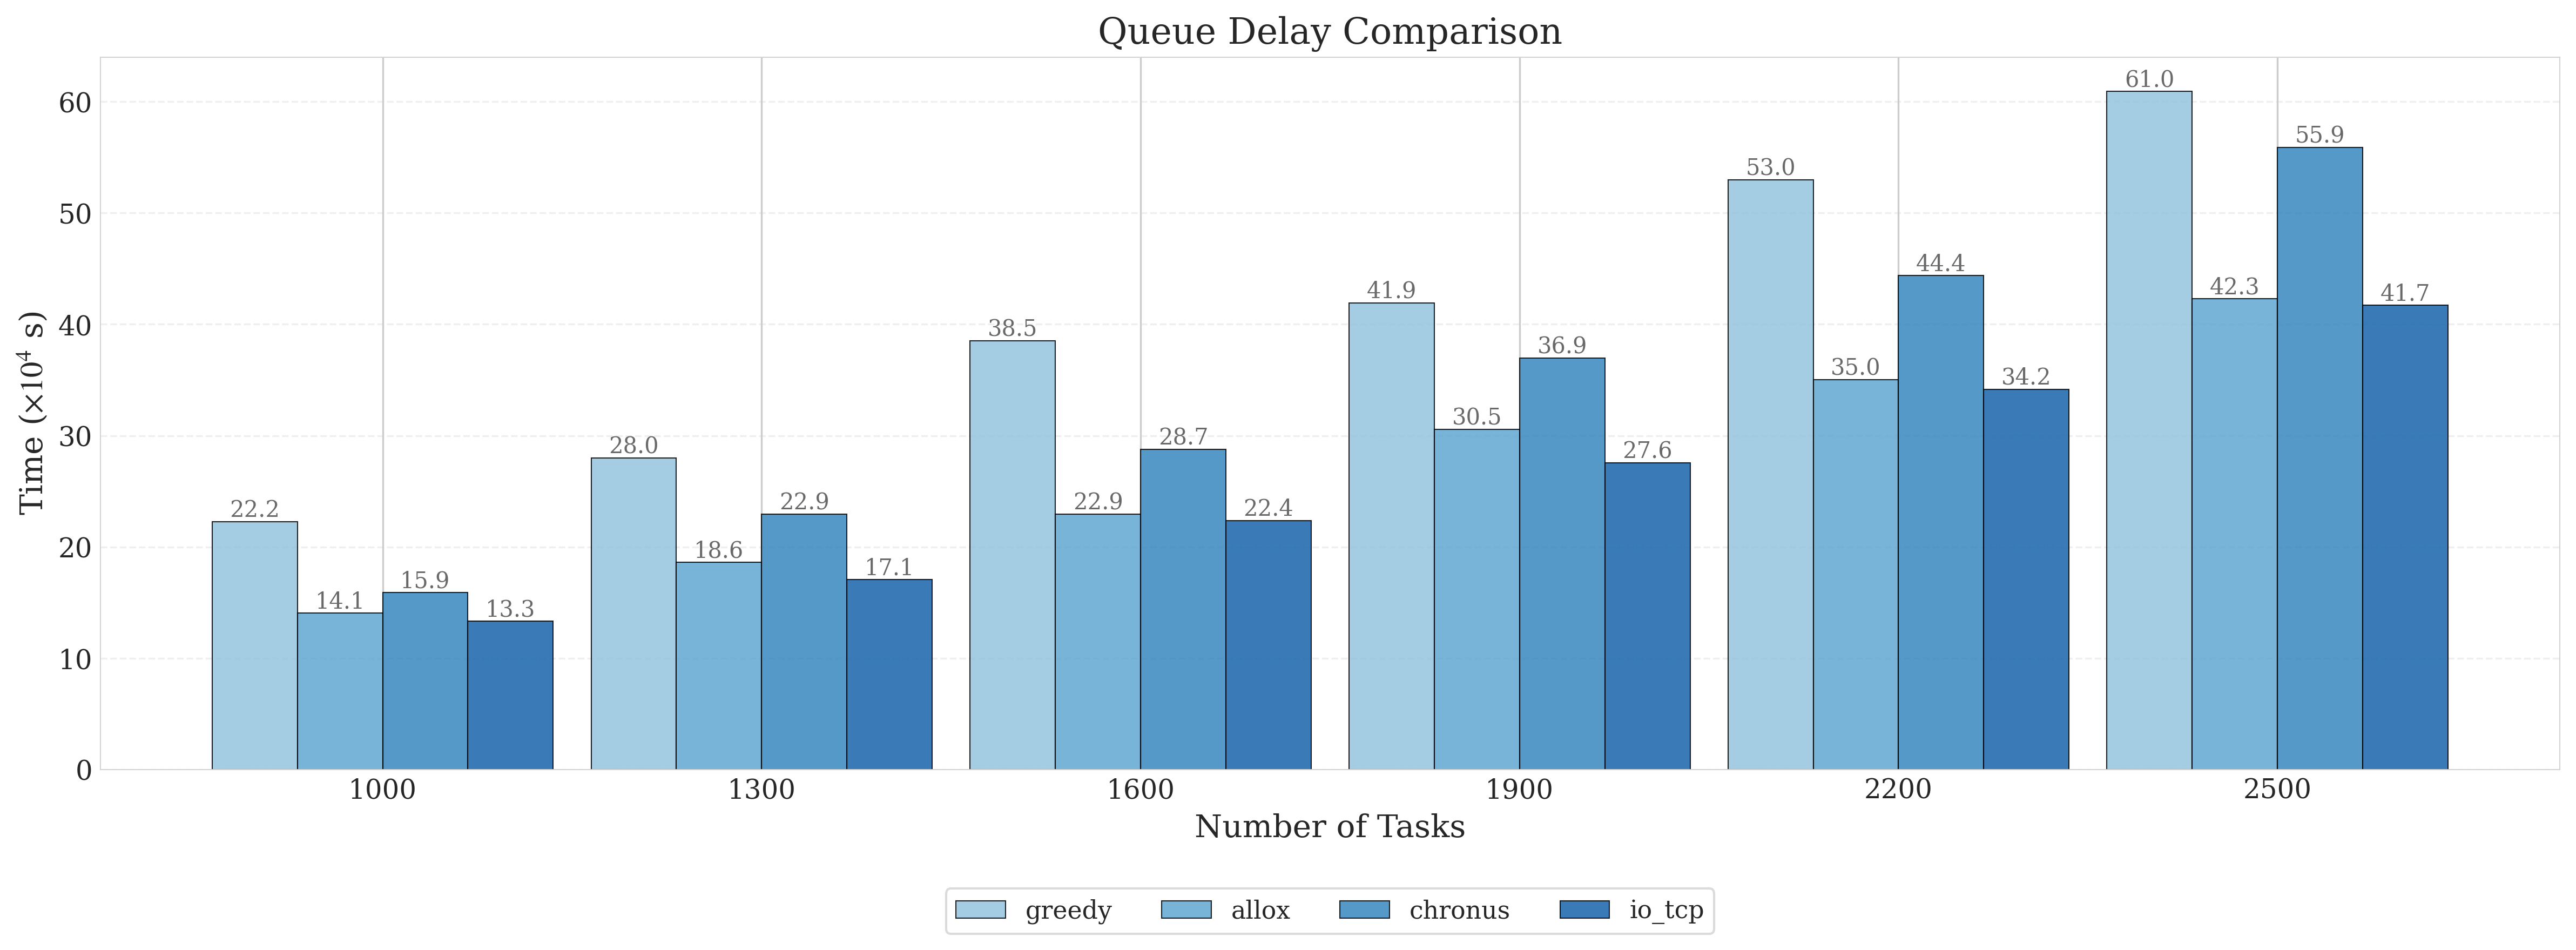

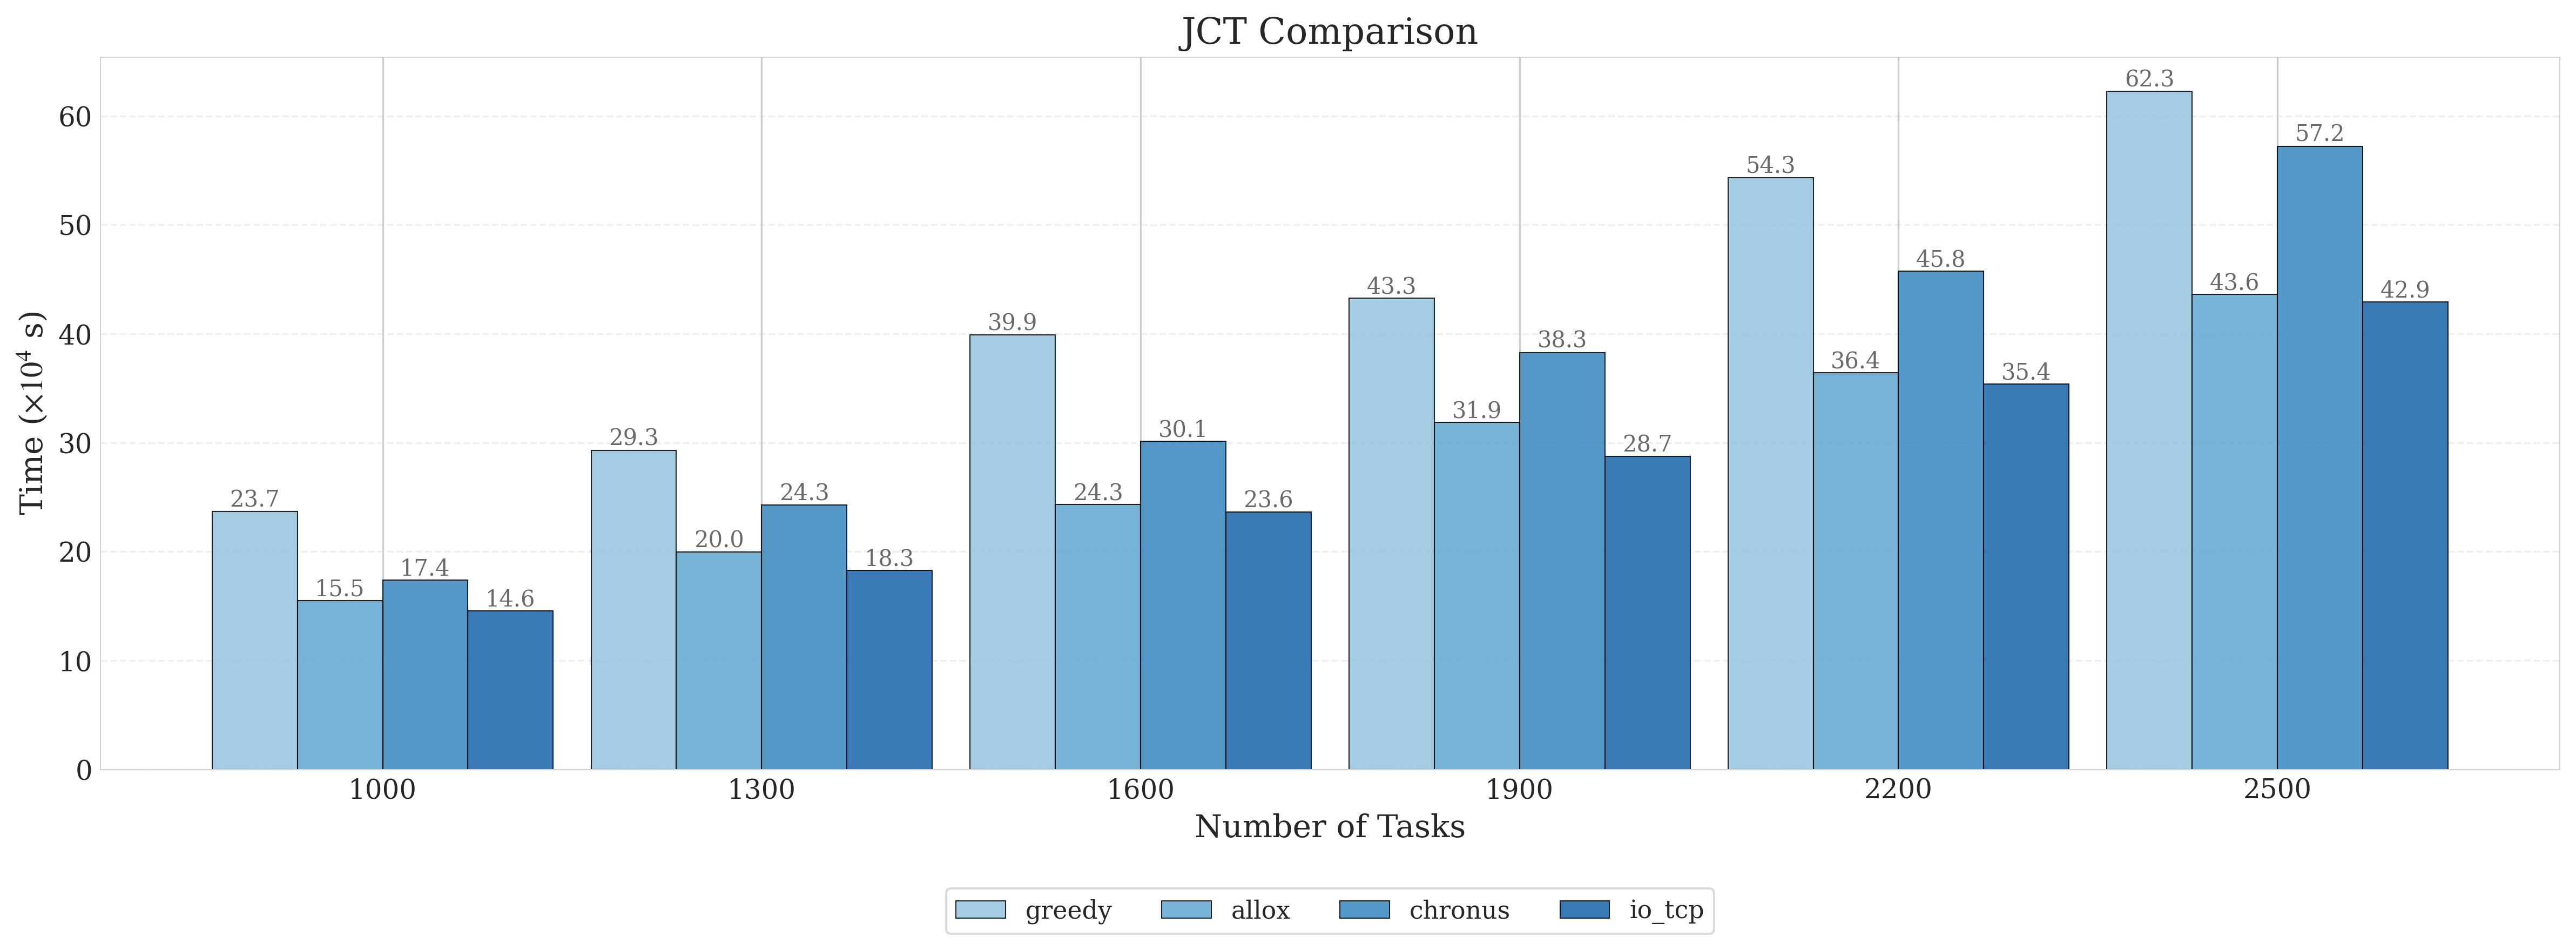

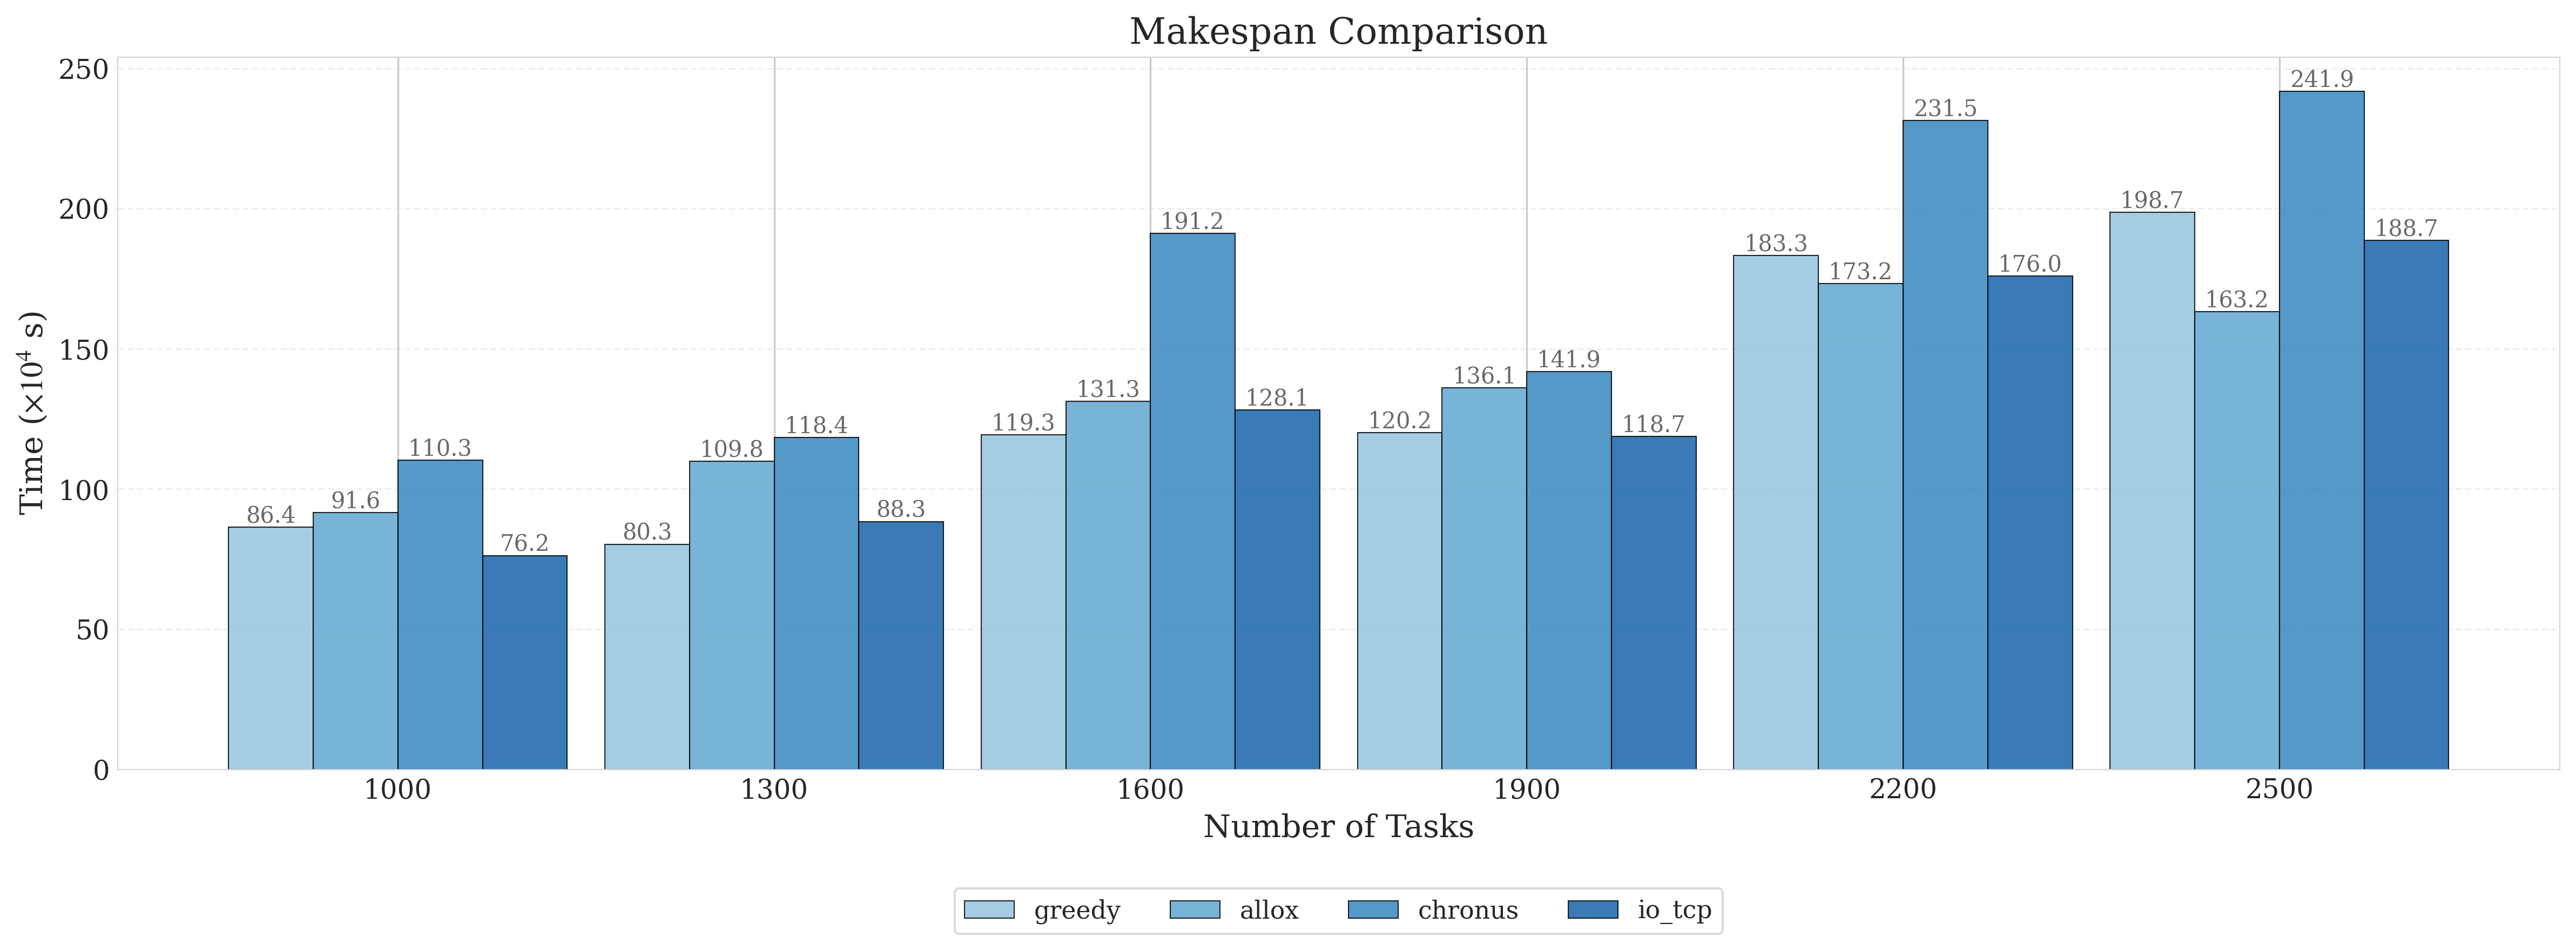

In [2]:
def plot_metrics_comparison(results_dict):
    """绘制不同任务数量下各调度器的性能比较柱状图"""
    import matplotlib.pyplot as plt
    import numpy as np

    # 设置绘图样式
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams.update(
        {
            "font.family": "serif",
            "font.serif": ["Times New Roman", "DejaVu Serif", "Palatino", "serif"],
            "mathtext.fontset": "stix",
            "axes.labelsize": 14,  # 从11增加到14
            "axes.titlesize": 16,  # 从12增加到16
            "xtick.labelsize": 12,  # 从10增加到12
            "ytick.labelsize": 12,  # 从10增加到12
            "legend.fontsize": 11,  # 从9增加到11
        }
    )

    # 获取调度器列表和任务数量列表
    schedulers = list(results_dict[list(results_dict.keys())[0]].keys())
    jobs_counts = sorted(list(results_dict.keys()))  # 确保任务数量有序

    # 使用不同的颜色方案
    colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(schedulers)))

    # 设置柱状图的宽度
    width = 0.90 / len(schedulers)  # 根据调度器数量自动调整宽度

    # 指标列表
    metrics = [("avg_queue_time", "Queue Delay"), ("avg_running_time", "JCT"), ("total_runtime", "Makespan")]

    # 为每个指标创建单独的图
    for metric_attr, metric_name in metrics:
        plt.figure(figsize=(16, 6), dpi=300)
        ax = plt.gca()

        # 为每个调度器绘制柱状图
        for scheduler_idx, scheduler in enumerate(schedulers):
            x_positions = np.arange(len(jobs_counts))
            values = [results_dict[jobs_count][scheduler].__getattribute__(metric_attr) for jobs_count in jobs_counts]

            # 计算柱子的位置
            x = x_positions + scheduler_idx * width - (len(schedulers) - 1) * width / 2

            # 绘制柱状图
            bars = ax.bar(
                x,
                [v / 1e4 for v in values],
                width,
                label=scheduler,
                color=colors[scheduler_idx],
                edgecolor="black",
                linewidth=0.5,
                alpha=0.85,
            )

            # 添加数据标签
            for i, v in enumerate(values):
                ax.text(x[i], v / 1e4, f"{v/1e4:.1f}", ha="center", va="bottom", fontsize=10, color="dimgray")

        # 设置图表样式
        ax.set_title(f"{metric_name} Comparison")
        ax.set_xlabel("Number of Tasks")
        ax.set_ylabel("Time ($\\times 10^4$ s)")

        # 设置x轴刻度
        ax.set_xticks(x_positions)
        ax.set_xticklabels(jobs_counts)

        # 设置网格线
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)

        # 美化边框
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            spine.set_color("lightgray")

        # 添加图例
        plt.legend(
            bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=len(schedulers), frameon=True, edgecolor="lightgray"
        )

        # 调整布局
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)

        plt.show()
        plt.close()


# 使用示例
plot_metrics_comparison(results_dict)

In [3]:
def calculate_metrics_reduction(results_dict, compare_scheduler):
    """计算CED策略相对于其他调度器的各项指标降低百分比

    Args:
        results_dict: 包含不同任务数量下各调度器结果的字典

    Returns:
        dict: 每个任务数量下各指标的降低百分比
    """
    metrics_reduction = {}

    # 遍历每个任务数量
    for job_count in results_dict.keys():
        metrics_reduction[job_count] = {"queue_delay": {}, "jct": {}, "makespan": {}}

        results = results_dict[job_count]

        # 获取CED的基准值
        ced_queue_delay = results[compare_scheduler].avg_queue_time
        ced_jct = results[compare_scheduler].avg_running_time
        ced_makespan = results[compare_scheduler].total_runtime

        # 计算相对于其他调度器的降低百分比
        for scheduler in results.keys():
            if scheduler == compare_scheduler:
                continue

            # 计算队列等待时间降低百分比
            queue_delay = results[scheduler].avg_queue_time
            queue_reduction = ((queue_delay - ced_queue_delay) / queue_delay) * 100
            metrics_reduction[job_count]["queue_delay"][scheduler] = queue_reduction

            # 计算JCT降低百分比
            jct = results[scheduler].avg_running_time
            jct_reduction = ((jct - ced_jct) / jct) * 100
            metrics_reduction[job_count]["jct"][scheduler] = jct_reduction

            # 计算Makespan降低百分比
            makespan = results[scheduler].total_runtime
            makespan_reduction = ((makespan - ced_makespan) / makespan) * 100
            metrics_reduction[job_count]["makespan"][scheduler] = makespan_reduction

    return metrics_reduction


def print_metrics_reduction(metrics_reduction):
    """打印各项指标的降低百分比"""
    metrics_names = {"queue_delay": "Queue Delay", "jct": "JCT", "makespan": "Makespan"}

    for job_count in metrics_reduction.keys():
        print(f"\n任务数量: {job_count}")
        for metric_key, metric_name in metrics_names.items():
            print(f"\n{base_scheduler}的{metric_name}降低百分比相对于其他调度器:")
            for scheduler, reduction in metrics_reduction[job_count][metric_key].items():
                print(f"{scheduler}: 降低了 {reduction:.2f}%")


# 使用示例
metrics_reduction = calculate_metrics_reduction(results_dict, base_scheduler)
print_metrics_reduction(metrics_reduction)

KeyError: 'sc_rm'